In [1]:
%load_ext autoreload
%reload_ext autoreload


In [2]:
import numpy as np
import open3d as o3d
from datetime import datetime
from PIL import Image

from utils import *
from bpy_utils import ManusData, get_fbx_creation_time

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure
from manus.sensors import SensorsLocation

In [3]:
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/real_data/data/20210722/round_2_fixed_wooden_cube/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/real_data/data/20210722/round_3_fixed_bottle_pose_1/"
recording_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/real_data/data/20210727_woIMU/r3/"

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("recording:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".fbx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 07272021_3.hdf5
recording: 20210727_173327
manus_file: recording_2021-07-27_16-34-36.fbx


# Load data

In [4]:
%%capture

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir, use_txt=False)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

manus = ManusData(manus_pth, manopth_dir)

glove_sensor_path = os.path.join(manopth_dir, 'data/glove_vis_sensor_new.csv')
sensors_location = SensorsLocation(glove_sensor_path)

# Synchronize

#### Get timestamps

In [5]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
#pyfbx_i42_pth = "C:/Users/lucas/Desktop/UPC/MIT/pyfbx_i42-master/"
#ts_end = get_fbx_creation_time(manus_pth, pyfbx_i42_pth)
#ts_start = ts_end - len(manus) / 20
ts_manus = manus.get_ts(fps=19.67)

#### Find pressure camera offset


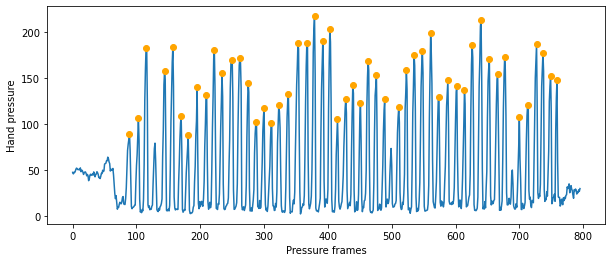

In [6]:
pressure.plot_peaks(height=80)

In [7]:
# Index of first pressure peak 
idx_first_p = pressure.get_peaks(height=80)[0]
# Timestamp of first pressure peak
ts_first_p = pressure.ts_touch[idx_first_p]

# Frame of first pressure in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
pc_offset = ts_first_p - ts_first_c

#### Find manus camera offset


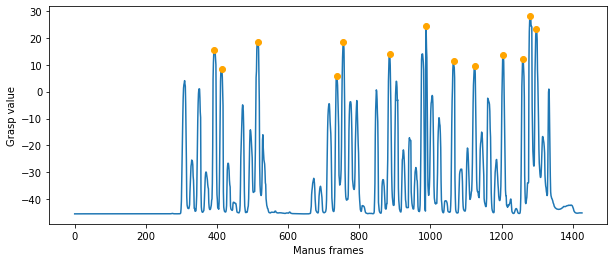

In [8]:
manus.plot_grasps(height=5)

In [9]:
# Index of first manus grasp peak 
idx_first_m = manus.get_grasps(height=5)[0]
# Timestamp of first manus grasp peak
ts_first_m = ts_manus[idx_first_m]

# Frame of first grasp in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
mc_offset = ts_first_m - ts_first_c

In [28]:
datetime.utcfromtimestamp(ts_first_m) - datetime.utcfromtimestamp(ts_first_c)

datetime.timedelta(days=3, seconds=78566, microseconds=396340)

#### Synchronize pressure + camera + manus

In [10]:
synchronize = Synchronizer(ts_p=ts_pressure, ts_c=ts_camera, ts_m=ts_manus, pc_offset=pc_offset, mc_offset=mc_offset)

# Project MANO to camera

#### Load viewpoints

In [11]:
width = 640
height = 480

cx = width / 2 - 0.5
cy = height / 2 - 0.5

for camera in cameras:
    camera_viewpoint = o3d.camera.PinholeCameraParameters()
    camera_viewpoint.extrinsic = extrinsics.from_camera(camera=camera)
    fx, fy, _, _ = intrinsics.params_from_camera(camera=camera)
    camera_viewpoint.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

    viewpoint_file = os.path.join(cameras_dir, f"{camera}_viewpoint.json")
    o3d.io.write_pinhole_camera_parameters(viewpoint_file, camera_viewpoint)

#### View single frame from single camera

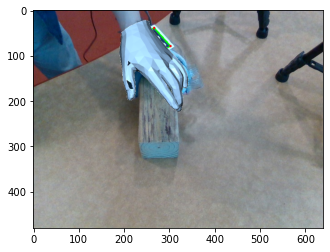

In [12]:
frame_c = 1140 #590,1200
frame_c = str(frame_c).zfill(6)
frame_m = synchronize.camera_to_manus(frame_c)
#pcd = stitched_pcd[frame_c]

camera = cameras[1]
viewpoint_file = os.path.join(cameras_dir, f"{camera}_viewpoint.json")

corners_w = apriltags.corners_w(idx=frame_c)

if corners_w is not None:
    rectangle = get_rectangle_from_corners(corners_w)
    mesh_hand = manus.from_corners(frame_m, corners_w)
    
    img_mano = save_draw_geometries(mesh_hand, None, viewpoint_file, width=width, height=height).astype(np.uint8)
    img_camera = apriltags.from_idx_camera(frame_c, camera).get_image(show=False)
    
    white_idx = np.argwhere(np.sum(img_mano, axis=-1) > 764)
    img_camera_mano = img_mano
    img_camera_mano[white_idx[:,0],white_idx[:,1],:] = img_camera[white_idx[:,0], white_idx[:,1],:]
    
    plt.imshow(img_camera_mano)

#### Save from one camera

In [23]:
camera = cameras[1]

out_dir = os.path.join(apriltags.cameras_dir, "imgs", "camera_manus", camera)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
viewpoint_file = os.path.join(cameras_dir, f"{camera}_viewpoint.json")


for frame_c in range(0, 1759): #1759
    frame_c = str(frame_c).zfill(6)
    frame_m = synchronize.camera_to_manus(frame_c)

    img_camera = apriltags.from_idx_camera(frame_c, camera).get_image(show=False) 

    corners_w = apriltags.corners_w(idx=frame_c)
    
    if corners_w is None:
        im = Image.fromarray(img_camera, 'RGB')
        
    
    else:
        rectangle = get_rectangle_from_corners(corners_w)
        mesh_hand = manus.from_corners(frame_m, corners_w)

        img_mano = save_draw_geometries([mesh_hand, rectangle], None, viewpoint_file, width=width, height=height)


        white_idx = np.argwhere(np.sum(img_mano, axis=-1)  > 764)
        img_camera_mano = img_mano
        img_camera_mano[white_idx[:,0],white_idx[:,1],:] = img_camera[white_idx[:,0], white_idx[:,1],:]
        
        im = Image.fromarray(img_camera_mano, 'RGB')
    
    out_pth = os.path.join(out_dir, f"img_{frame_c}.png")
    im.save(out_pth)